In [0]:
%load_ext rpy2.ipython

In [0]:
%%capture
%%R
#capture to avoid seeing all the loading/install messages 
#%%capture basically avoids any stdout/stderr on the cell
if (!require("ggplot2")) install.packages('ggplot2')
if (!require("forecast")) install.packages('forecast', dependencies = TRUE)
if (!require("tidyverse")) install.packages('tidyverse')
if (!require("KFAS")) install.packages('KFAS')
if (!require("data.table")) install.packages('data.table')

In [0]:
%%R

library("ggplot2")
library("forecast")
library("tidyverse")
library("KFAS")

#if having problem with forecast package:
#!sudo rm -rf /usr/local/lib/R/site-library/00LOCK-RcppArmadillo
#and rexecute the cell above, otherwise use R by typing !R in a new cell
#and correct the error manually

In [0]:
%%R 

in_df <- read.csv2("time_series_dataset.csv", dec = ".")
in_df$Data <- as.Date(in_df$Data)
head(df)

in_df[in_df$Data=="2012-02-29" | in_df$Data=="2016-02-29",] 
#remove the leap year dates
df <- in_df[-which(in_df$Data=="2012-02-29" | in_df$Data=="2016-02-29"),] 

Splittiamo il dataset in train e test per verificare come va il modello su nuovi dati.

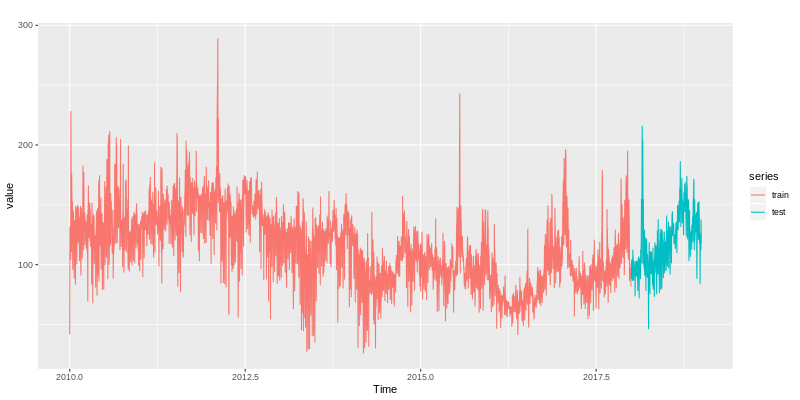

In [45]:
%%R -w 800 -h 400
idata <- ts(df$value, start=c(2010,1), frequency=365) 
train <- window(idata, start=c(2010,1), end=c(2017,365))
#train <- df[1:(nrow(df) - 365),] #last one year is for validation
test <- window(idata, start=c(2018,1), end=c(2018,365))

autoplot(cbind(train, test)) + ylab("value")

# ARIMA with R

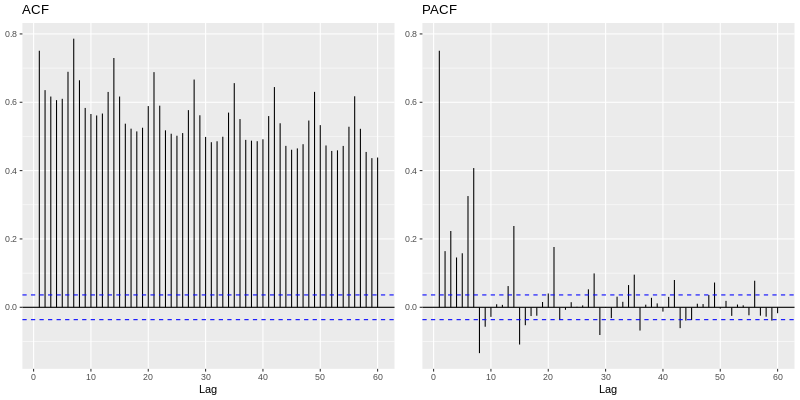

In [46]:
%%R -w 800 -h 400
## ------------------------------------------------------------------------
#This is the function ggtsdisplay of forecast package, 
#but it has been modified so is doesn't plot the series,
#just the ACF and PACF plot, with the horizontal parameter 
#the plot can be either horizontal or vertical
#The function has been simplified a lot, since we don't need 
#all the complexity the original one has.
ggtsdisplay_2 <- function(x, lag.max, horizontal=TRUE, ...) {
    if (!is.ts(x)) {
      x <- ts(x)
    }
    if (missing(lag.max)) {
      lag.max <- round(min(max(10 * log10(length(x)), 3 * frequency(x)), length(x) / 3))
    }
    ######      END   CHECKING    ########
    
    # Set up grid for plots
    if (horizontal){
      gridlayout <- matrix(c(2, 3), nrow = 1)
    }
    else{
      gridlayout <- matrix(c(2, 3), nrow = 2)
    }
    grid::grid.newpage()
    grid::pushViewport(grid::viewport(layout = grid::grid.layout(nrow(gridlayout), ncol(gridlayout))))
    
    # Prepare Acf plot
    acfplot <- do.call(ggAcf, c(x = quote(x), lag.max = lag.max)) +
      ggplot2::ggtitle("ACF") + ggplot2::ylab(NULL)

    # Prepare last plot (variable)
    pacfplot <- ggPacf(x, lag.max = lag.max) + ggplot2::ggtitle("PACF") +
      ggplot2::ylab(NULL)
    # Match y-axis
    acfplotrange <- ggplot2::layer_scales(acfplot)$y$range$range
    pacfplotrange <- ggplot2::layer_scales(pacfplot)$y$range$range
    yrange <- range(c(acfplotrange, pacfplotrange))
    acfplot <- acfplot + ggplot2::ylim(yrange)
    pacfplot <- pacfplot + ggplot2::ylim(yrange)

    # Add ACF plot
    matchidx <- as.data.frame(which(gridlayout == 2, arr.ind = TRUE))
    print(
      acfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )

    # Add PACF plot
    matchidx <- as.data.frame(which(gridlayout == 3, arr.ind = TRUE))
    print(
      pacfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )
  
}

ggtsdisplay_2(train, horizontal = TRUE, lag.max = 60)


Possiamo vedere che nel PACF vi sono 7 ritardi e il ritrado stagionale che scende esponenzialemente al settimo ritardo, indicando la presenza di un SMA$(1)_7$ e vedendo ACF dai primi 2 ritardi stagionali ci convinciamo dell'esistenza di SMA$(1)_7$, inoltre vi è presente anche un SAR$(1)_7$. Stagionalità 7 indica un periodo settimanale in questa serie. Inoltre vista la discesa lenta e non geometrica della ACF potrebbe suggerire l'esistenza di una integrazione stagionale. Iniziamo ad aggiungere la parte stagionale prima e cerchiamo di capire dai residui come andrebbe aggiustato il modello.

Series: train 
ARIMA(0,0,0)(1,0,1)[7] with non-zero mean 
Box Cox transformation: lambda= 0.8062425 

Coefficients:
        sar1     sma1     mean
      0.9585  -0.5495  55.6316
s.e.  0.0064   0.0228   1.3456

sigma^2 estimated as 49.58:  log likelihood=-9845.76
AIC=19699.52   AICc=19699.54   BIC=19723.44


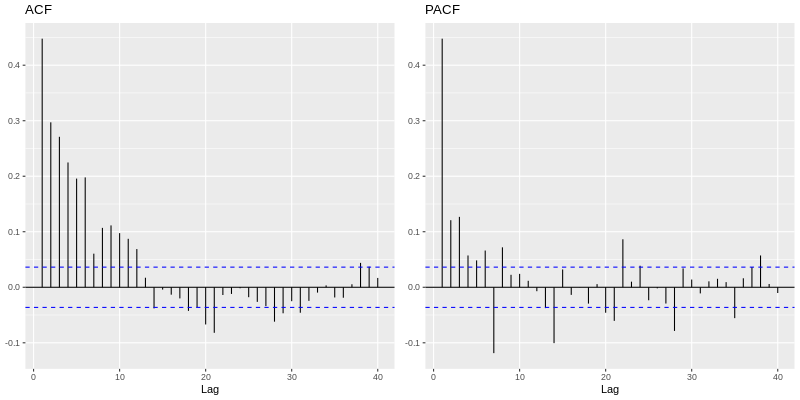

In [47]:
%%R -w 800 -h 400
mod1 <- Arima(train, c(0,0,0), list(order=c(1,0,1), period=7), lambda = "auto")
ggtsdisplay_2(mod1$residuals, lag.max = 40)
mod1

Vediamo anche che il coefficiente di SAR è molto vicino ad 1, quindi ha radice unitaria e ciò dice che esiste l'integrazione stagionale che sospettavamo prima.

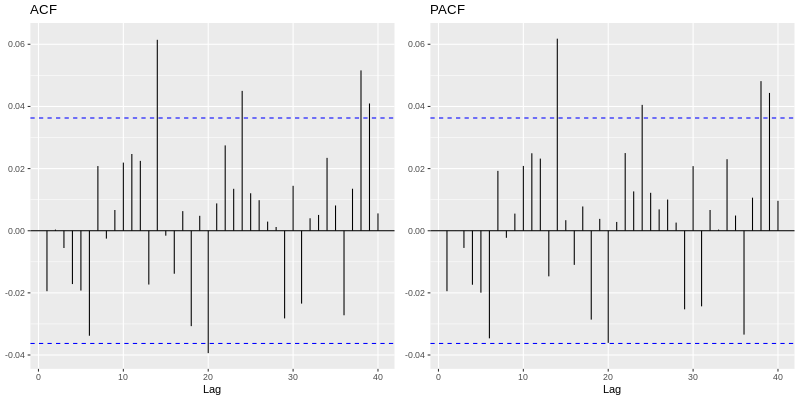

In [48]:
%%R -w 800 -h 400
mod2 <- Arima(train, c(6,0,0), list(order=c(1,1,1), period=7), lambda = "auto")
mod2
ggtsdisplay_2(mod2$residuals, lag.max = 40)

I residui sembrano essere rientrati nella banda tranne un residuo a 14 sia un ACF che PACF.

Usiamo il test Augmented Dickey-Fuller, che cerca radici unitarie nella serie, per verificare se la serie è stazionaria, con k che indica il ritardo autoregressivo, $H_0$ è la presenza di radici unitarie nella serie, $H_1$ è che la serie è stazionaria.


	Augmented Dickey-Fuller Test

data:  mod2$residuals
Dickey-Fuller = -19.907, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



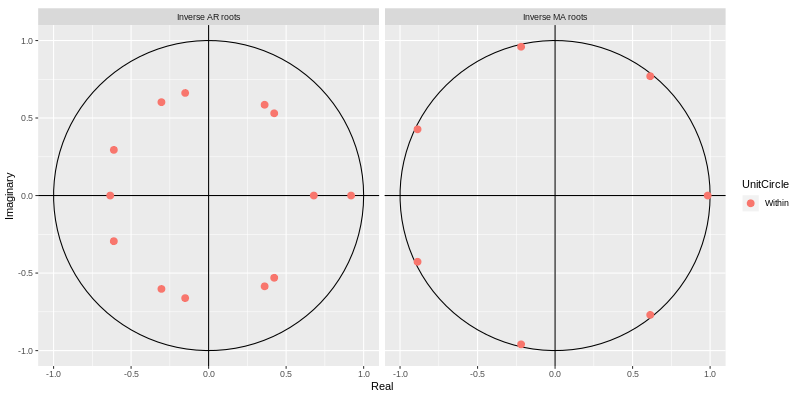

In [49]:
%%R -w 800 -h 400
#Trying Augmeted Dickey-Fuller test to see if the series is stationary:
#$H_0$ is that the model is not stationary
print(tseries::adf.test(mod2$residuals, k=7))
        
#Another way, it shows the roots
autoplot(mod2)

Poiché il p-value è basso rifiutiamo l'$H_0$ e possiamo dire che i residui della sono stazionari. Questo è per il modello AR, mentre per SAR lo abbiamo già visto prima.

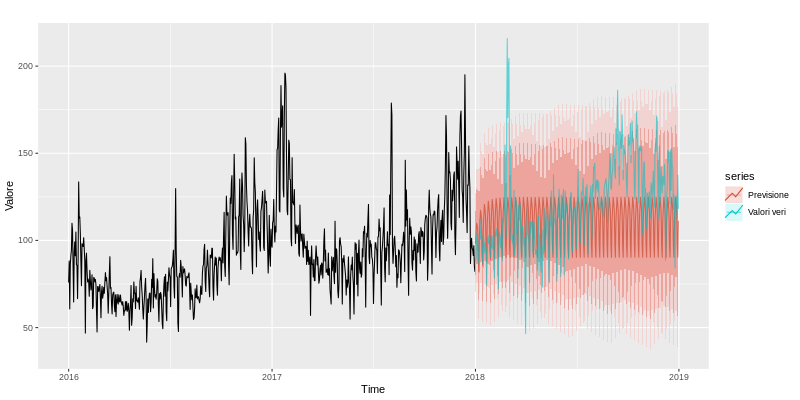

In [50]:
%%R -w 800 -h 400
pred <- forecast(mod2, h=365)

autoplot(window(idata, start=c(2016,1), end=c(2017,365))) +
  autolayer(pred,series="Previsione", alpha=0.7) +
  autolayer(test, series="Valori veri", alpha=0.6) +
  xlab("Time") +
  ylab("Valore")

Questa serie presenta in realtà una multi-stagionalità, che non può essere risolta con R, per questo si prova ad usare regressori esterni, introducendo una stagionalità annuale e ogni 4 settimane quindi mettiamo regressori dummy mensili e ogni 4 settimane.

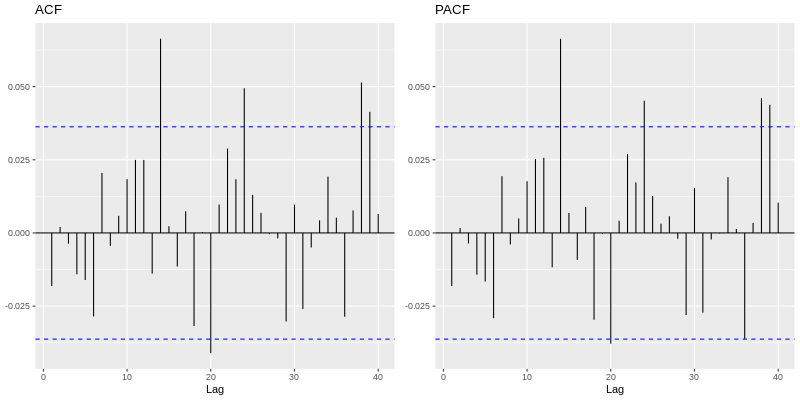

In [51]:
%%R -w 800 -h 400
#create dummy
data.frame(Data=df$Data) %>%
  mutate(M = months(Data), ind = 1) %>%
  spread(M, ind, fill = 0) %>%
  mutate(W = paste0("W",(data.table::week(Data) %% 4 + 1)), ind=1) %>%
  spread(W, ind, fill = 0) %>%
  select(-starts_with("Data")) %>% as.matrix() -> more_reg

#eliminiamo la prima e l'ultima colonna, per evitare multicollinearità
xreg <- more_reg[,2:(ncol(more_reg)-1)] 

mod1_reg <- Arima(train, c(6,0,0), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], include.constant = TRUE, lambda = "auto")

ggtsdisplay_2(mod1_reg$residuals, lag.max = 40)

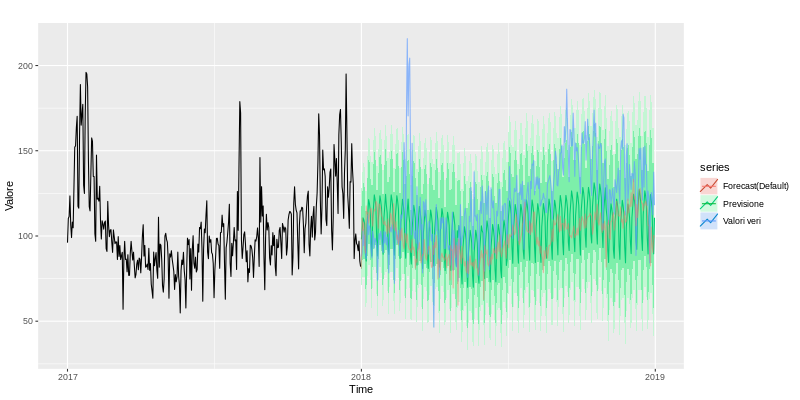

In [52]:
%%R -w 800 -h 400
pred_reg <- forecast(mod1_reg, h=365, 
              xreg=xreg[(length(train)+1):(length(train)+365),])
autoplot(pred_reg)

autoplot(window(idata, start=c(2017,1), end=c(2017,365))) +
  autolayer(pred_reg,series="Previsione") +
  autolayer(test, series="Valori veri", alpha=0.7)+
  autolayer(forecast(train, h=365)$mean, alpha=0.5, series="Forecast(Default)") +
  ylab("Valore")

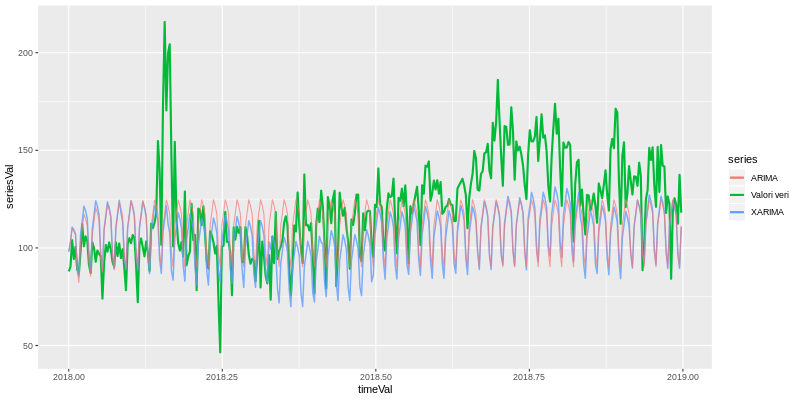

In [53]:
%%R -w 800 -h 400
mod_reg_y <- forecast(mod1_reg, h=365, 
                 xreg=xreg[(nrow(df)-365+1):(length(train)+365),])$mean
mod2_y <- forecast(mod2, h=365)$mean

ggplot() +
  autolayer(test, series="Valori veri", size=1) +
  autolayer(pred_reg$mean,series="XARIMA", size=0.7, alpha=0.8) +
  autolayer(pred$mean,series="ARIMA", alpha=0.7)
  #autolayer(forecast(train, h=365)$mean, alpha=0.7, series="Forecast")

In realtà si nota che il modello performa peggio sul validation se vengono fornite regressori esterni per indicare il mese e la settimana, ciò è dovuto al fatto che nell'ultimo anno l'andamento è diverso dagli ultimi anni, oppure queste variabili non sono tanto esplicative quanto si credeva e aggiungono solo del rumore alla previsione.

# UCM with R

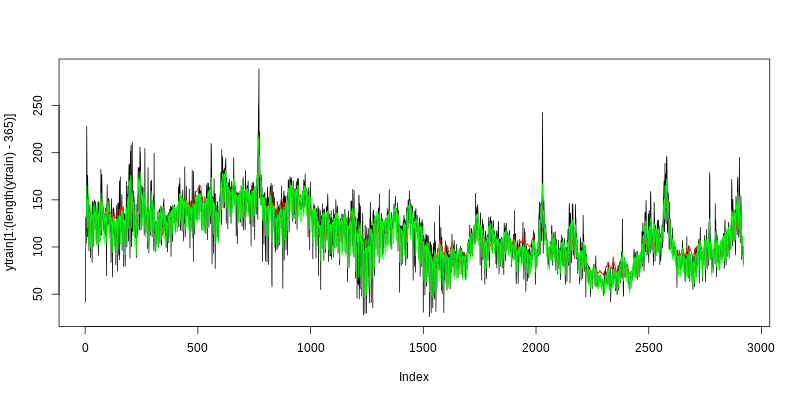

In [54]:
%%R -w 800 -h 400

ytrain <- as.numeric(train)
ytrain[(length(ytrain)+1):(length(ytrain)+365)] <- NA


mod1 <- SSModel(ytrain ~ 0 +
                  SSMtrend(1, NA) +
                  SSMseasonal(7, NA, "dummy") +
                  SSMseasonal(365, 0, "trig",
                              harmonics = 1:12),
                H = NA)

vary <- var(ytrain, na.rm = TRUE)
mod1$P1inf <- mod1$P1inf * 0
mod1$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(mod1$P1) <- vary

# Initial values for the variances we have to estimate
init <- numeric(3)
init[1] <- log(vary/10) # log-var(dist.rw)
init[2] <- log(vary/100)# log-var(dist.seas)
init[3] <- log(vary/10) # log-var(err.oss.)

# Estimate
fit1 <- fitSSM(mod1, init)
fit1$optim.out$convergence

smo1 <- KFS(fit1$model, smoothing = c("state", "disturbance", "signal"))
smo1_seas <- rowSums(smo1$alphahat[1:(length(ytrain) -365), seq(8, 27, 2)])

plot(ytrain[1:(length(ytrain) -365)], type = "l")
lines(smo1$alphahat[1:(length(ytrain) -365), "level"], col = "red")
lines(smo1$alphahat[1:(length(ytrain) -365), "level"] +
        smo1_seas[1:(length(ytrain) -365)], col = "blue")
lines(smo1$alphahat[1:(length(ytrain) -365), "level"] +
        smo1$alphahat[1:(length(ytrain) -365), "sea_dummy1"] +
        smo1_seas[1:(length(ytrain) -365)], col = "green")


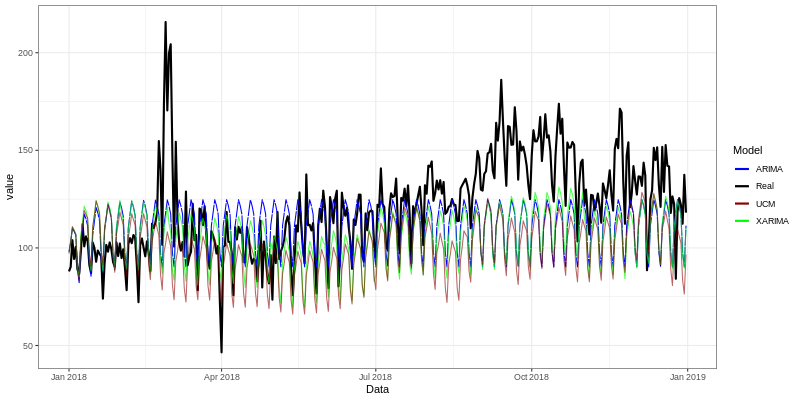

In [55]:
%%R -w 800 -h 400

ucm_y <- smo1$muhat[(length(train)+1):length(ytrain)]


df[((length(train)+1):length(ytrain)),] %>%
  mutate(UCM = ucm_y,
         XARIMA = as.numeric(pred_reg$mean), 
         ARIMA = as.numeric(pred$mean)) %>%
  ggplot(aes(x=Data)) + 
  geom_line(aes(y=value ,col="Real"),size=1) +
  geom_line(aes(y=ARIMA, col="ARIMA"), linetype="F1") +
  geom_line(aes(y=XARIMA, col="XARIMA"), alpha=0.7) +
  geom_line(aes(y=UCM, col="UCM"), alpha=0.6) +
  scale_color_manual(name = "Model",
                     values= c("Real"="black",
                               "UCM"="darkred",
                               "ARIMA"="blue",
                               "XARIMA"="green")) +
  theme_bw()


# LSTM with python

In [0]:
%%capture
!pip install parameter-sherpa

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import time

%matplotlib inline

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)

import sherpa #AutoML

from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("Tesorflow Version:", tf.__version__)
print("Keras Version:",tf.keras.__version__)

Tesorflow Version: 2.1.0-rc1
Keras Version: 2.2.4-tf


In [7]:
df = pd.read_csv("drive/My Drive/ts_proj/time_series_dataset.csv", sep=";", decimal=".")
df.Data = pd.to_datetime(df.Data)
df.head()

,Data,value
0,2010-01-01,41.651044
1,2010-01-02,131.286604
2,2010-01-03,117.388117
3,2010-01-04,116.461280
4,2010-01-05,123.823765


In [0]:
df.drop(df[df.Data == "2012-02-29"].index, inplace=True)
df.drop(df[df.Data == "2012-02-29"].index, inplace=True)

In [0]:
train = df[df.Data <= pd.to_datetime("2017-12-31")]
test  = df[df.Data  > pd.to_datetime("2017-12-31")]

In [10]:
train.tail()

,Data,value
2917,2017-12-27,94.68432
2918,2017-12-28,91.35400
2919,2017-12-29,96.96372
2920,2017-12-30,85.41000
2921,2017-12-31,82.01000


In [11]:
test.head()

,Data,value
2922,2018-01-01,87.95964
2923,2018-01-02,90.30000
2924,2018-01-03,103.95000
2925,2018-01-04,94.34287
2926,2018-01-05,100.53000


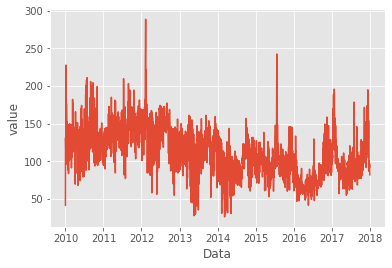

In [12]:
sns.lineplot(train.Data,train.value)
plt.show()

In [0]:
x_scaler = StandardScaler().\
            fit(np.array(train.value).reshape(-1,1))

x_scaled = x_scaler.transform(np.array(train.value).reshape(-1,1))

In [0]:
def sliding_windows(data, seq_length, pred_lenght):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_lenght-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length:i+seq_length+pred_lenght])

    return np.array(x),np.array(y)

In [0]:
INPUT_SIZE = 365*2 #2 years
OUTPUT_SIZE = 365


slides = sliding_windows(x_scaled, 
                         INPUT_SIZE ,OUTPUT_SIZE)

X_train = slides[0].reshape(slides[0].shape[0],
                            slides[0].shape[1],
                           1)
y_train = slides[1]

In [16]:
X_train.shape

(1825, 730, 1)

In [17]:
y_train.shape

(1825, 365, 1)

In [0]:
X_test = np.expand_dims(x_scaled[-INPUT_SIZE:], axis=0) 
y_test = x_scaler.transform(np.array(test.value).reshape(-1,1)).reshape(-1,365,1) #LAST Year

In [0]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
  initial = Input(shape=(INPUT_SIZE,1))

  x = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

  x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
  x = Dense(int(params["hidden_unit2"]), activation='relu')(x)

  out = Dense(OUTPUT_SIZE, activation='linear')(x)

  model = Model(initial, out)

  model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

  hist = model.fit(X_train, y_train, validation_data=(X_test, y_test),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
  return model, model.evaluate(X_test, y_test)[0], hist

In [0]:
parameters = [sherpa.Discrete('lstm_unit',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
X_test = np.expand_dims(x_scaled[-INPUT_SIZE:], axis=0)

best_score = 999999

for trial in study:
    start_time = time.time()
    print("Trial ", trial.id, " with parameters ", trial.parameters)
  
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
      score = 999999
      print("Model Crashed or 'NaNed'")
      
    if score != 999999:
      study.add_observation(trial, iteration=1, objective=score)
      if score < best_score:
        model.save("drive/My Drive/ts_proj/best_model.h5")
        best_model   = model
        best_score   = score
        best_history = hist
      else:
        del model #free RAM
      study.finalize(trial)
      print("Score: ", score, " || Took ",str(time.time()-start_time), "Seconds")
      study.results.to_csv("drive/My Drive/ts_proj/AutoML.csv")

Trial  1  with parameters  {'lstm_unit': 138, 'hidden_unit1': 308, 'hidden_unit2': 282, 'lr_init': 0.0011060427838310318, 'batch_size': 64}
Epoch 00089: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 2.4357 - mae: 1.3315


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Score:  2.4356751441955566  || Took  126.88864135742188 Seconds
Trial  2  with parameters  {'lstm_unit': 52, 'hidden_unit1': 291, 'hidden_unit2': 454, 'lr_init': 0.0012288567553639614, 'batch_size': 128}
Epoch 00079: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.0303 - mae: 0.8496
Score:  1.0302611589431763  || Took  37.04144239425659 Seconds
Trial  3  with parameters  {'lstm_unit': 88, 'hidden_unit1': 467, 'hidden_unit2': 429, 'lr_init': 0.0033249995930725125, 'batch_size': 128}
Epoch 00055: early stopping
1/1 [==============================] - 0s 15ms/sample - loss: 1.0174 - mae: 0.8325
Score:  1.017366886138916  || Took  34.78704023361206 Seconds
Trial  4  with parameters  {'lstm_unit': 99, 'hidden_unit1': 356, 'hidden_unit2': 323, 'lr_init': 0.0008938759130214364, 'batch_size': 256}
Epoch 00055: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.0184 - mae: 0.8020
Score:  1.0184497833251953  || Took  27.584766626358032 Se

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.2069107294082642  || Took  67.303227186203 Seconds
Trial  7  with parameters  {'lstm_unit': 93.0, 'hidden_unit1': 460.0, 'hidden_unit2': 438.0, 'lr_init': 0.004991029177856614, 'batch_size': 64.0}
Epoch 00076: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 2.3320 - mae: 1.2972


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.331976890563965  || Took  82.67115688323975 Seconds
Trial  8  with parameters  {'lstm_unit': 62.0, 'hidden_unit1': 420.0, 'hidden_unit2': 313.0, 'lr_init': 0.004597795304432795, 'batch_size': 256.0}
Epoch 00067: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.1407 - mae: 0.8708


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1406939029693604  || Took  27.310477256774902 Seconds
Trial  9  with parameters  {'lstm_unit': 59.0, 'hidden_unit1': 420.0, 'hidden_unit2': 315.0, 'lr_init': 0.0013507241995628382, 'batch_size': 128.0}
Epoch 00066: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.0069 - mae: 0.8216


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0068509578704834  || Took  35.71987509727478 Seconds
Trial  10  with parameters  {'lstm_unit': 86.0, 'hidden_unit1': 470.0, 'hidden_unit2': 425.0, 'lr_init': 0.002651063779608508, 'batch_size': 128.0}
Epoch 00061: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.0840 - mae: 0.8258


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0840080976486206  || Took  42.17366313934326 Seconds
Trial  11  with parameters  {'lstm_unit': 57.0, 'hidden_unit1': 423.0, 'hidden_unit2': 322.0, 'lr_init': 0.0010827459199678484, 'batch_size': 128.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1720 - mae: 0.8763


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1720023155212402  || Took  27.105916261672974 Seconds
Trial  12  with parameters  {'lstm_unit': 95.0, 'hidden_unit1': 349.0, 'hidden_unit2': 321.0, 'lr_init': 0.003092971423384337, 'batch_size': 64.0}
Epoch 00059: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.4483 - mae: 1.0198


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.4483343362808228  || Took  66.5671820640564 Seconds
Trial  13  with parameters  {'lstm_unit': 102.0, 'hidden_unit1': 362.0, 'hidden_unit2': 325.0, 'lr_init': 0.0005, 'batch_size': 256.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.9707 - mae: 0.7666


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9706741571426392  || Took  27.457008600234985 Seconds
Trial  14  with parameters  {'lstm_unit': 107.0, 'hidden_unit1': 359.0, 'hidden_unit2': 319.0, 'lr_init': 0.0005, 'batch_size': 256.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.2849 - mae: 0.9012


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.2848889827728271  || Took  27.06892704963684 Seconds
Trial  15  with parameters  {'lstm_unit': 96.0, 'hidden_unit1': 361.0, 'hidden_unit2': 329.0, 'lr_init': 0.0005, 'batch_size': 256.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.3594 - mae: 0.9373


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.3594272136688232  || Took  22.48269820213318 Seconds
Trial  16  with parameters  {'lstm_unit': 52.0, 'hidden_unit1': 417.0, 'hidden_unit2': 313.0, 'lr_init': 0.0005, 'batch_size': 128.0}
1/1 [==============================] - 0s 11ms/sample - loss: 0.9486 - mae: 0.7737


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9486483335494995  || Took  47.561408042907715 Seconds
Trial  17  with parameters  {'lstm_unit': 56.0, 'hidden_unit1': 412.0, 'hidden_unit2': 317.0, 'lr_init': 0.0005, 'batch_size': 128.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.1762 - mae: 0.8604


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1761893033981323  || Took  24.60634994506836 Seconds
Trial  18  with parameters  {'lstm_unit': 52.0, 'hidden_unit1': 292.0, 'hidden_unit2': 464.0, 'lr_init': 0.001726807433392719, 'batch_size': 64.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 1.5217 - mae: 1.0400


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.5216987133026123  || Took  42.448566198349 Seconds
Trial  19  with parameters  {'lstm_unit': 53.0, 'hidden_unit1': 424.0, 'hidden_unit2': 311.0, 'lr_init': 0.0005, 'batch_size': 128.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1506 - mae: 0.8574


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1505823135375977  || Took  25.936084985733032 Seconds
Trial  20  with parameters  {'lstm_unit': 52.0, 'hidden_unit1': 290.0, 'hidden_unit2': 446.0, 'lr_init': 0.0008278922649269105, 'batch_size': 128.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1495 - mae: 0.8786


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.149549961090088  || Took  24.80490493774414 Seconds
Trial  21  with parameters  {'lstm_unit': 43.0, 'hidden_unit1': 416.0, 'hidden_unit2': 314.0, 'lr_init': 0.005, 'batch_size': 128.0}
Epoch 00066: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.1332 - mae: 0.8716


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1332365274429321  || Took  32.416218280792236 Seconds
Trial  22  with parameters  {'lstm_unit': 106.0, 'hidden_unit1': 357.0, 'hidden_unit2': 329.0, 'lr_init': 0.0010539461446312118, 'batch_size': 256.0}
Epoch 00079: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.9732 - mae: 0.7849


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9732394218444824  || Took  41.290668964385986 Seconds
Trial  23  with parameters  {'lstm_unit': 110.0, 'hidden_unit1': 365.0, 'hidden_unit2': 331.0, 'lr_init': 0.001690663380285365, 'batch_size': 256.0}
Epoch 00062: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.7857 - mae: 0.6978


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7856823205947876  || Took  33.319053173065186 Seconds
Trial  24  with parameters  {'lstm_unit': 114.0, 'hidden_unit1': 364.0, 'hidden_unit2': 336.0, 'lr_init': 0.005, 'batch_size': 128.0}
Epoch 00071: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 1.6497 - mae: 1.0801


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.6496559381484985  || Took  59.58270072937012 Seconds
Trial  25  with parameters  {'lstm_unit': 108.0, 'hidden_unit1': 365.0, 'hidden_unit2': 328.0, 'lr_init': 0.0005, 'batch_size': 256.0}
Epoch 00068: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.4530 - mae: 0.9755


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.4530028104782104  || Took  31.98397731781006 Seconds
Trial  26  with parameters  {'lstm_unit': 235.0, 'hidden_unit1': 334.0, 'hidden_unit2': 256.0, 'lr_init': 0.004467842328191083, 'batch_size': 64.0}
1/1 [==============================] - 0s 13ms/sample - loss: 0.8658 - mae: 0.7334


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8657590746879578  || Took  198.42837691307068 Seconds
Trial  27  with parameters  {'lstm_unit': 45.0, 'hidden_unit1': 419.0, 'hidden_unit2': 317.0, 'lr_init': 0.0011946082893606312, 'batch_size': 128.0}
1/1 [==============================] - 0s 10ms/sample - loss: 0.9849 - mae: 0.8109


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9849382042884827  || Took  48.83475184440613 Seconds
Trial  28  with parameters  {'lstm_unit': 133.0, 'hidden_unit1': 478.0, 'hidden_unit2': 430.0, 'lr_init': 0.004073639980398114, 'batch_size': 64.0}
Epoch 00082: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 2.3942 - mae: 1.2355


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.3942177295684814  || Took  107.83363461494446 Seconds
Trial  29  with parameters  {'lstm_unit': 70.0, 'hidden_unit1': 479.0, 'hidden_unit2': 411.0, 'lr_init': 0.0005, 'batch_size': 128.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.1178 - mae: 0.8343


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1177785396575928  || Took  32.17901301383972 Seconds
Trial  30  with parameters  {'lstm_unit': 66.0, 'hidden_unit1': 417.0, 'hidden_unit2': 310.0, 'lr_init': 0.0036042263756342497, 'batch_size': 256.0}
Epoch 00063: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.0480 - mae: 0.7985


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0480250120162964  || Took  28.465065240859985 Seconds
Trial  31  with parameters  {'lstm_unit': 110.0, 'hidden_unit1': 364.0, 'hidden_unit2': 334.0, 'lr_init': 0.004168991503104064, 'batch_size': 64.0}
Epoch 00087: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.2178 - mae: 0.8813


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.2178272008895874  || Took  104.50086855888367 Seconds
Trial  32  with parameters  {'lstm_unit': 67.0, 'hidden_unit1': 481.0, 'hidden_unit2': 407.0, 'lr_init': 0.004774077329134062, 'batch_size': 128.0}
Epoch 00065: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.9148 - mae: 0.7954


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.914815366268158  || Took  40.25684094429016 Seconds
Trial  33  with parameters  {'lstm_unit': 152.0, 'hidden_unit1': 510.0, 'hidden_unit2': 441.0, 'lr_init': 0.00491286914651368, 'batch_size': 128.0}
Epoch 00066: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.8248 - mae: 1.1489


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.8248273134231567  || Took  55.93520665168762 Seconds
Trial  34  with parameters  {'lstm_unit': 54.0, 'hidden_unit1': 419.0, 'hidden_unit2': 316.0, 'lr_init': 0.0013049913532516793, 'batch_size': 128.0}
Epoch 00061: early stopping
1/1 [==============================] - 0s 14ms/sample - loss: 1.0073 - mae: 0.8185


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.007295846939087  || Took  31.751732349395752 Seconds
Trial  35  with parameters  {'lstm_unit': 250.0, 'hidden_unit1': 340.0, 'hidden_unit2': 256.0, 'lr_init': 0.005, 'batch_size': 64.0}
Epoch 00084: early stopping
1/1 [==============================] - 0s 15ms/sample - loss: 0.8144 - mae: 0.7277


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8143724799156189  || Took  179.6433482170105 Seconds
Trial  36  with parameters  {'lstm_unit': 250.0, 'hidden_unit1': 354.0, 'hidden_unit2': 256.0, 'lr_init': 0.0015878050704108979, 'batch_size': 256.0}
Epoch 00052: early stopping
1/1 [==============================] - 0s 13ms/sample - loss: 1.3071 - mae: 0.9075


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.3070780038833618  || Took  51.51724338531494 Seconds
Trial  37  with parameters  {'lstm_unit': 249.0, 'hidden_unit1': 317.0, 'hidden_unit2': 256.0, 'lr_init': 0.005, 'batch_size': 64.0}
1/1 [==============================] - 0s 14ms/sample - loss: 0.9746 - mae: 0.7757


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9746043682098389  || Took  210.8964283466339 Seconds
Trial  38  with parameters  {'lstm_unit': 186.0, 'hidden_unit1': 385.0, 'hidden_unit2': 344.0, 'lr_init': 0.0010578676494585938, 'batch_size': 128.0}
Epoch 00093: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.7992 - mae: 0.6879


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7991928458213806  || Took  98.10972714424133 Seconds
Trial  39  with parameters  {'lstm_unit': 219.0, 'hidden_unit1': 297.0, 'hidden_unit2': 290.0, 'lr_init': 0.0038417412793867295, 'batch_size': 128.0}
Epoch 00082: early stopping
1/1 [==============================] - 0s 15ms/sample - loss: 1.2731 - mae: 0.9187


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.2730937004089355  || Took  95.63767981529236 Seconds
Trial  40  with parameters  {'lstm_unit': 198.0, 'hidden_unit1': 390.0, 'hidden_unit2': 344.0, 'lr_init': 0.0005, 'batch_size': 128.0}
1/1 [==============================] - 0s 11ms/sample - loss: 0.8216 - mae: 0.6902


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8215596675872803  || Took  114.43228888511658 Seconds
Trial  41  with parameters  {'lstm_unit': 103.0, 'hidden_unit1': 359.0, 'hidden_unit2': 325.0, 'lr_init': 0.0041500835522183645, 'batch_size': 128.0}
Epoch 00097: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.9268 - mae: 0.7808


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.926796019077301  || Took  72.54030585289001 Seconds
Trial  42  with parameters  {'lstm_unit': 201.0, 'hidden_unit1': 384.0, 'hidden_unit2': 353.0, 'lr_init': 0.0005, 'batch_size': 256.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.3986 - mae: 0.9551


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.3986072540283203  || Took  43.01217341423035 Seconds
Trial  43  with parameters  {'lstm_unit': 183.0, 'hidden_unit1': 398.0, 'hidden_unit2': 328.0, 'lr_init': 0.0005, 'batch_size': 128.0}
1/1 [==============================] - 0s 11ms/sample - loss: 0.7394 - mae: 0.6558


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7393807172775269  || Took  103.32707023620605 Seconds
Trial  44  with parameters  {'lstm_unit': 183.0, 'hidden_unit1': 402.0, 'hidden_unit2': 326.0, 'lr_init': 0.0005, 'batch_size': 128.0}
Epoch 00051: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1594 - mae: 0.8835


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1594241857528687  || Took  53.25524282455444 Seconds
Trial  45  with parameters  {'lstm_unit': 182.0, 'hidden_unit1': 388.0, 'hidden_unit2': 332.0, 'lr_init': 0.0005, 'batch_size': 128.0}
1/1 [==============================] - 0s 11ms/sample - loss: 0.9538 - mae: 0.7736


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9537801146507263  || Took  103.05046343803406 Seconds
Trial  46  with parameters  {'lstm_unit': 181.0, 'hidden_unit1': 392.0, 'hidden_unit2': 336.0, 'lr_init': 0.005, 'batch_size': 128.0}
Epoch 00076: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 2.0818 - mae: 1.1765


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.081831693649292  || Took  78.09255504608154 Seconds
Trial  47  with parameters  {'lstm_unit': 183.0, 'hidden_unit1': 397.0, 'hidden_unit2': 327.0, 'lr_init': 0.0005, 'batch_size': 128.0}
1/1 [==============================] - 0s 11ms/sample - loss: 0.8685 - mae: 0.7248


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8684886693954468  || Took  102.62060070037842 Seconds
Trial  48  with parameters  {'lstm_unit': 185.0, 'hidden_unit1': 398.0, 'hidden_unit2': 329.0, 'lr_init': 0.0005, 'batch_size': 128.0}
Epoch 00098: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.7505 - mae: 0.6598


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7505383491516113  || Took  102.38955235481262 Seconds
Trial  49  with parameters  {'lstm_unit': 183.0, 'hidden_unit1': 399.0, 'hidden_unit2': 330.0, 'lr_init': 0.0005, 'batch_size': 128.0}
Epoch 00091: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.9382 - mae: 0.7640


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9381697177886963  || Took  93.5600049495697 Seconds
Trial  50  with parameters  {'lstm_unit': 247.0, 'hidden_unit1': 339.0, 'hidden_unit2': 256.0, 'lr_init': 0.004945913123955887, 'batch_size': 64.0}
Epoch 00076: early stopping
1/1 [==============================] - 0s 13ms/sample - loss: 1.1988 - mae: 0.8716


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1987663507461548  || Took  160.30539727210999 Seconds
Trial  51  with parameters  {'lstm_unit': 185.0, 'hidden_unit1': 399.0, 'hidden_unit2': 328.0, 'lr_init': 0.005, 'batch_size': 128.0}
Epoch 00063: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 2.0087 - mae: 1.1218


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.0086581707000732  || Took  66.81905627250671 Seconds
Trial  52  with parameters  {'lstm_unit': 101.0, 'hidden_unit1': 484.0, 'hidden_unit2': 364.0, 'lr_init': 0.00158750289285853, 'batch_size': 256.0}
Epoch 00061: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 0.8628 - mae: 0.7294


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8628100156784058  || Took  30.734491109848022 Seconds
Trial  53  with parameters  {'lstm_unit': 177.0, 'hidden_unit1': 331.0, 'hidden_unit2': 431.0, 'lr_init': 0.0029348391558687097, 'batch_size': 128.0}
Epoch 00097: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.9736 - mae: 0.7339


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.973560631275177  || Took  98.6720564365387 Seconds
Trial  54  with parameters  {'lstm_unit': 85.0, 'hidden_unit1': 440.0, 'hidden_unit2': 402.0, 'lr_init': 0.0038176321206625737, 'batch_size': 64.0}
Epoch 00056: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.4179 - mae: 0.9569


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.4178675413131714  || Took  56.91526794433594 Seconds
Trial  55  with parameters  {'lstm_unit': 84.0, 'hidden_unit1': 470.0, 'hidden_unit2': 425.0, 'lr_init': 0.001254619559287712, 'batch_size': 64.0}
Epoch 00065: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1009 - mae: 0.8655


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.10088050365448  || Took  58.99926805496216 Seconds
Trial  56  with parameters  {'lstm_unit': 240.0, 'hidden_unit1': 382.0, 'hidden_unit2': 427.0, 'lr_init': 0.003375818432118111, 'batch_size': 256.0}
Epoch 00069: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 1.0440 - mae: 0.7773


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.044004201889038  || Took  57.642184257507324 Seconds
Trial  57  with parameters  {'lstm_unit': 130.0, 'hidden_unit1': 291.0, 'hidden_unit2': 290.0, 'lr_init': 0.0019192415289109256, 'batch_size': 64.0}
Epoch 00092: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.8523 - mae: 0.7522


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8523203134536743  || Took  123.98318338394165 Seconds
Trial  58  with parameters  {'lstm_unit': 141.0, 'hidden_unit1': 466.0, 'hidden_unit2': 445.0, 'lr_init': 0.004244866264743797, 'batch_size': 256.0}
Epoch 00093: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.0359 - mae: 0.8440


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0359115600585938  || Took  53.692769050598145 Seconds
Trial  59  with parameters  {'lstm_unit': 125.0, 'hidden_unit1': 429.0, 'hidden_unit2': 486.0, 'lr_init': 0.003127959306297454, 'batch_size': 128.0}
1/1 [==============================] - 0s 10ms/sample - loss: 0.8228 - mae: 0.7272


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8228336572647095  || Took  84.98641467094421 Seconds
Trial  60  with parameters  {'lstm_unit': 45.0, 'hidden_unit1': 272.0, 'hidden_unit2': 349.0, 'lr_init': 0.002182136480809213, 'batch_size': 128.0}
Epoch 00085: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.2198 - mae: 0.9193


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.219804048538208  || Took  41.09811449050903 Seconds
Trial  61  with parameters  {'lstm_unit': 174.0, 'hidden_unit1': 305.0, 'hidden_unit2': 357.0, 'lr_init': 0.003162670096949787, 'batch_size': 256.0}
Epoch 00096: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.2446 - mae: 0.9344


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.244613766670227  || Took  64.64852285385132 Seconds
Trial  62  with parameters  {'lstm_unit': 84.0, 'hidden_unit1': 471.0, 'hidden_unit2': 423.0, 'lr_init': 0.0020353977218634453, 'batch_size': 128.0}
Epoch 00057: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.9035 - mae: 0.7593


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9035319685935974  || Took  35.38748359680176 Seconds
Trial  63  with parameters  {'lstm_unit': 72.0, 'hidden_unit1': 324.0, 'hidden_unit2': 341.0, 'lr_init': 0.003975495556257442, 'batch_size': 256.0}
Epoch 00067: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.2661 - mae: 0.9149


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.266108751296997  || Took  27.05687713623047 Seconds
Trial  64  with parameters  {'lstm_unit': 204.0, 'hidden_unit1': 355.0, 'hidden_unit2': 446.0, 'lr_init': 0.000758609370440558, 'batch_size': 256.0}
Epoch 00053: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.0211 - mae: 0.8079


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.021064281463623  || Took  38.58193397521973 Seconds
Trial  65  with parameters  {'lstm_unit': 196.0, 'hidden_unit1': 433.0, 'hidden_unit2': 425.0, 'lr_init': 0.003491261958069358, 'batch_size': 128.0}
Epoch 00077: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.5089 - mae: 1.0402


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.5089068412780762  || Took  76.62737703323364 Seconds
Trial  66  with parameters  {'lstm_unit': 250.0, 'hidden_unit1': 407.0, 'hidden_unit2': 391.0, 'lr_init': 0.0023639009588036705, 'batch_size': 256.0}
Epoch 00074: early stopping
1/1 [==============================] - 0s 14ms/sample - loss: 1.2460 - mae: 0.9203


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.2460116147994995  || Took  72.83130145072937 Seconds
Trial  67  with parameters  {'lstm_unit': 184.0, 'hidden_unit1': 373.0, 'hidden_unit2': 505.0, 'lr_init': 0.0026432509939882994, 'batch_size': 128.0}
Epoch 00064: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.8347 - mae: 1.1107


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.8346734046936035  || Took  57.98245644569397 Seconds
Trial  68  with parameters  {'lstm_unit': 82.0, 'hidden_unit1': 360.0, 'hidden_unit2': 366.0, 'lr_init': 0.003563788117151017, 'batch_size': 256.0}
Epoch 00057: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.0382 - mae: 0.8069


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0381770133972168  || Took  27.110323429107666 Seconds
Trial  69  with parameters  {'lstm_unit': 208.0, 'hidden_unit1': 388.0, 'hidden_unit2': 292.0, 'lr_init': 0.002084903574523784, 'batch_size': 64.0}
Epoch 00091: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.0986 - mae: 0.8840


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0985972881317139  || Took  139.53016924858093 Seconds
Trial  70  with parameters  {'lstm_unit': 101.0, 'hidden_unit1': 286.0, 'hidden_unit2': 368.0, 'lr_init': 0.0048455180010784134, 'batch_size': 128.0}
Epoch 00080: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.7447 - mae: 0.6730


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.744667112827301  || Took  58.85464358329773 Seconds
Trial  71  with parameters  {'lstm_unit': 25.0, 'hidden_unit1': 267.0, 'hidden_unit2': 413.0, 'lr_init': 0.0035159909791497943, 'batch_size': 64.0}
Epoch 00074: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 2.3121 - mae: 1.2455


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.312138319015503  || Took  59.757070779800415 Seconds
Trial  72  with parameters  {'lstm_unit': 144.0, 'hidden_unit1': 422.0, 'hidden_unit2': 407.0, 'lr_init': 0.004688410298786366, 'batch_size': 128.0}
Epoch 00063: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.7361 - mae: 0.6499


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7361335754394531  || Took  53.189777851104736 Seconds
Trial  73  with parameters  {'lstm_unit': 128.0, 'hidden_unit1': 494.0, 'hidden_unit2': 506.0, 'lr_init': 0.004724094418395504, 'batch_size': 64.0}
1/1 [==============================] - 0s 10ms/sample - loss: 0.5725 - mae: 0.5988


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.5724765062332153  || Took  110.04041647911072 Seconds
Trial  74  with parameters  {'lstm_unit': 149.0, 'hidden_unit1': 454.0, 'hidden_unit2': 433.0, 'lr_init': 0.002521925507074898, 'batch_size': 64.0}
Epoch 00057: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.5629 - mae: 1.0383


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.5629428625106812  || Took  81.06548190116882 Seconds
Trial  75  with parameters  {'lstm_unit': 230.0, 'hidden_unit1': 341.0, 'hidden_unit2': 267.0, 'lr_init': 0.0009225261991323413, 'batch_size': 128.0}
Epoch 00059: early stopping
1/1 [==============================] - 0s 13ms/sample - loss: 1.1821 - mae: 0.8885


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1820766925811768  || Took  75.02069163322449 Seconds
Trial  76  with parameters  {'lstm_unit': 181.0, 'hidden_unit1': 406.0, 'hidden_unit2': 498.0, 'lr_init': 0.0035991718873392845, 'batch_size': 64.0}
Epoch 00076: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 1.0930 - mae: 0.8586


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0930176973342896  || Took  119.5688304901123 Seconds
Trial  77  with parameters  {'lstm_unit': 126.0, 'hidden_unit1': 509.0, 'hidden_unit2': 331.0, 'lr_init': 0.0012575344793606907, 'batch_size': 256.0}
Epoch 00076: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.0271 - mae: 0.8167


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.027115821838379  || Took  41.38283586502075 Seconds
Trial  78  with parameters  {'lstm_unit': 118.0, 'hidden_unit1': 390.0, 'hidden_unit2': 351.0, 'lr_init': 0.0008517212129968636, 'batch_size': 256.0}
Epoch 00052: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1370 - mae: 0.8372


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1370471715927124  || Took  28.064847946166992 Seconds
Trial  79  with parameters  {'lstm_unit': 204.0, 'hidden_unit1': 355.0, 'hidden_unit2': 283.0, 'lr_init': 0.0009603135904580819, 'batch_size': 256.0}
1/1 [==============================] - 0s 12ms/sample - loss: 0.7811 - mae: 0.6866


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7811325788497925  || Took  70.89308595657349 Seconds
Trial  80  with parameters  {'lstm_unit': 172.0, 'hidden_unit1': 342.0, 'hidden_unit2': 274.0, 'lr_init': 0.0025892313927041075, 'batch_size': 64.0}
Epoch 00085: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 0.9387 - mae: 0.7817


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9386911988258362  || Took  115.35562539100647 Seconds
Trial  81  with parameters  {'lstm_unit': 134.0, 'hidden_unit1': 266.0, 'hidden_unit2': 362.0, 'lr_init': 0.0021216385828026724, 'batch_size': 128.0}
Epoch 00059: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.9692 - mae: 0.8056


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9692273139953613  || Took  52.6248197555542 Seconds
Trial  82  with parameters  {'lstm_unit': 176.0, 'hidden_unit1': 360.0, 'hidden_unit2': 326.0, 'lr_init': 0.0008965523221440305, 'batch_size': 256.0}
Epoch 00055: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.2414 - mae: 0.9009


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.2413986921310425  || Took  33.14588284492493 Seconds
Trial  83  with parameters  {'lstm_unit': 84.0, 'hidden_unit1': 471.0, 'hidden_unit2': 422.0, 'lr_init': 0.004194249905886634, 'batch_size': 64.0}
Epoch 00098: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.8470 - mae: 0.7454


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8469510674476624  || Took  87.948805809021 Seconds
Trial  84  with parameters  {'lstm_unit': 51.0, 'hidden_unit1': 272.0, 'hidden_unit2': 418.0, 'lr_init': 0.0038487409029844305, 'batch_size': 256.0}
Epoch 00057: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.7308 - mae: 1.0658


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.730845332145691  || Took  20.66852378845215 Seconds
Trial  85  with parameters  {'lstm_unit': 164.0, 'hidden_unit1': 458.0, 'hidden_unit2': 455.0, 'lr_init': 0.004674697008667473, 'batch_size': 128.0}
Epoch 00085: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 2.0323 - mae: 1.1490


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.032299757003784  || Took  74.76644706726074 Seconds
Trial  86  with parameters  {'lstm_unit': 223.0, 'hidden_unit1': 352.0, 'hidden_unit2': 318.0, 'lr_init': 0.004014121489578642, 'batch_size': 64.0}
Epoch 00073: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 1.2901 - mae: 0.9081


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.290115237236023  || Took  136.42559957504272 Seconds
Trial  87  with parameters  {'lstm_unit': 54.0, 'hidden_unit1': 293.0, 'hidden_unit2': 454.0, 'lr_init': 0.0030627148221153283, 'batch_size': 128.0}
Epoch 00078: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 1.1684 - mae: 0.8667


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.168405294418335  || Took  39.91503071784973 Seconds
Trial  88  with parameters  {'lstm_unit': 115.0, 'hidden_unit1': 287.0, 'hidden_unit2': 412.0, 'lr_init': 0.002274866166728541, 'batch_size': 128.0}
1/1 [==============================] - 0s 10ms/sample - loss: 0.7745 - mae: 0.6630


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.774463951587677  || Took  82.29937791824341 Seconds
Trial  89  with parameters  {'lstm_unit': 129.0, 'hidden_unit1': 415.0, 'hidden_unit2': 390.0, 'lr_init': 0.000987664396699762, 'batch_size': 256.0}
Epoch 00055: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 1.0765 - mae: 0.8447


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.0764626264572144  || Took  31.42401432991028 Seconds
Trial  90  with parameters  {'lstm_unit': 206.0, 'hidden_unit1': 424.0, 'hidden_unit2': 467.0, 'lr_init': 0.0016445156269178757, 'batch_size': 256.0}
Epoch 00064: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.9170 - mae: 0.7615


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9169691801071167  || Took  53.19281768798828 Seconds
Trial  91  with parameters  {'lstm_unit': 139.0, 'hidden_unit1': 424.0, 'hidden_unit2': 294.0, 'lr_init': 0.0023463412041330595, 'batch_size': 64.0}
Epoch 00070: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.1974 - mae: 0.9072


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.1974003314971924  || Took  98.1857602596283 Seconds
Trial  92  with parameters  {'lstm_unit': 244.0, 'hidden_unit1': 448.0, 'hidden_unit2': 423.0, 'lr_init': 0.004086307337516842, 'batch_size': 64.0}
Epoch 00054: early stopping
1/1 [==============================] - 0s 14ms/sample - loss: 2.5315 - mae: 1.2707


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.531451940536499  || Took  98.18199896812439 Seconds
Trial  93  with parameters  {'lstm_unit': 96.0, 'hidden_unit1': 457.0, 'hidden_unit2': 454.0, 'lr_init': 0.0023483450209450564, 'batch_size': 128.0}
Epoch 00056: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 2.0523 - mae: 1.1636


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  2.052257537841797  || Took  34.56067895889282 Seconds
Trial  94  with parameters  {'lstm_unit': 51.0, 'hidden_unit1': 425.0, 'hidden_unit2': 312.0, 'lr_init': 0.004791503660795025, 'batch_size': 128.0}
1/1 [==============================] - 0s 16ms/sample - loss: 0.7363 - mae: 0.6508


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7362910509109497  || Took  49.77894926071167 Seconds
Trial  95  with parameters  {'lstm_unit': 62.0, 'hidden_unit1': 380.0, 'hidden_unit2': 497.0, 'lr_init': 0.0018570169753830885, 'batch_size': 256.0}
Epoch 00062: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 0.8010 - mae: 0.7026


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8009641766548157  || Took  25.675685167312622 Seconds
Trial  96  with parameters  {'lstm_unit': 124.0, 'hidden_unit1': 497.0, 'hidden_unit2': 312.0, 'lr_init': 0.0010474637689186113, 'batch_size': 128.0}
Epoch 00080: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 0.8517 - mae: 0.7268


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8517107963562012  || Took  61.6959171295166 Seconds
Trial  97  with parameters  {'lstm_unit': 76.0, 'hidden_unit1': 317.0, 'hidden_unit2': 306.0, 'lr_init': 0.001527176938088267, 'batch_size': 256.0}
Epoch 00096: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 0.7153 - mae: 0.6498


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.7153111696243286  || Took  40.06101322174072 Seconds
Trial  98  with parameters  {'lstm_unit': 189.0, 'hidden_unit1': 442.0, 'hidden_unit2': 431.0, 'lr_init': 0.001264203575782547, 'batch_size': 128.0}
Epoch 00080: early stopping
1/1 [==============================] - 0s 11ms/sample - loss: 1.3593 - mae: 0.9700


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  1.3593181371688843  || Took  83.20779347419739 Seconds
Trial  99  with parameters  {'lstm_unit': 72.0, 'hidden_unit1': 480.0, 'hidden_unit2': 410.0, 'lr_init': 0.004754210648493908, 'batch_size': 128.0}
Epoch 00054: early stopping
1/1 [==============================] - 0s 10ms/sample - loss: 0.8724 - mae: 0.7554


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.8724190592765808  || Took  29.541467905044556 Seconds
Trial  100  with parameters  {'lstm_unit': 169.0, 'hidden_unit1': 269.0, 'hidden_unit2': 294.0, 'lr_init': 0.001996156844723632, 'batch_size': 64.0}
Epoch 00074: early stopping
1/1 [==============================] - 0s 12ms/sample - loss: 0.9532 - mae: 0.8067
Score:  0.9531893134117126  || Took  116.36645174026489 Seconds


In [0]:
best_model = tf.keras.models.load_model('drive/My Drive/ts_proj/best_model.h5')
results = pd.read_csv("drive/My Drive/ts_proj/AutoML.csv")
results = results[results["Status"]=="COMPLETED"]

In [24]:
results.head()

,Unnamed: 0,Trial-ID,Status,Iteration,batch_size,hidden_unit1,hidden_unit2,lr_init,lstm_unit,Objective
1,1,1,COMPLETED,1,64.0,308.0,282.0,0.001106,138.0,2.435675
3,3,2,COMPLETED,1,128.0,291.0,454.0,0.001229,52.0,1.030261
5,5,3,COMPLETED,1,128.0,467.0,429.0,0.003325,88.0,1.017367
7,7,4,COMPLETED,1,256.0,356.0,323.0,0.000894,99.0,1.018450
9,9,5,COMPLETED,1,128.0,325.0,329.0,0.001250,135.0,1.539276


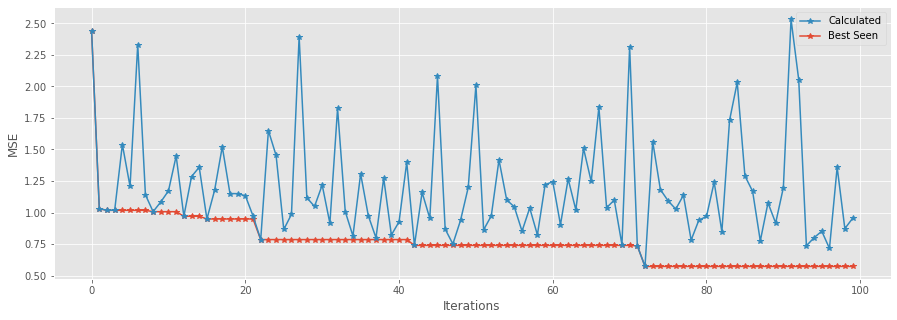

In [63]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

In [26]:
results.iloc[np.where(results.Objective == np.min(results.Objective))[0][0]]

Unnamed: 0             145
Trial-ID                73
Status           COMPLETED
Iteration                1
batch_size              64
hidden_unit1           494
hidden_unit2           506
lr_init         0.00472409
lstm_unit              128
Objective         0.572477
Name: 145, dtype: object

In [27]:
best_model.summary()

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 730, 1)]          0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_216 (Dense)            (None, 494)               63726     
_________________________________________________________________
dense_217 (Dense)            (None, 506)               250470    
_________________________________________________________________
dense_218 (Dense)            (None, 365)               185055    
Total params: 565,811
Trainable params: 565,811
Non-trainable params: 0
_________________________________________________________________


In [28]:
best_model.evaluate(X_train, y_train)
best_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 78ms/sample - loss: 0.5725 - mae: 0.5988


[0.5724765062332153, 0.5987937]

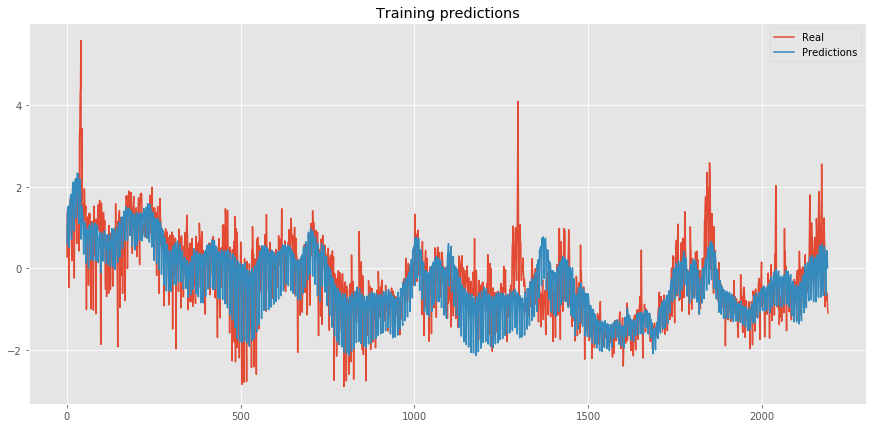

In [95]:
train_pred_0 = best_model.predict(np.expand_dims(X_train[0], axis=0))[0]
train_pred_1 = best_model.predict(np.expand_dims(X_train[OUTPUT_SIZE-1], axis=0))[0]
train_pred_2 = best_model.predict(np.expand_dims(X_train[OUTPUT_SIZE*2-1], axis=0))[0]
train_pred_3 = best_model.predict(np.expand_dims(X_train[OUTPUT_SIZE*2-1], axis=0))[0]
train_pred_4 = best_model.predict(np.expand_dims(X_train[OUTPUT_SIZE*4-1], axis=0))[0]
train_pred_5 = best_model.predict(np.expand_dims(X_train[OUTPUT_SIZE*5-1], axis=0))[0]

plt.figure(figsize=(15,7))

plt.plot(np.array(x_scaler.transform(np.array(train.value[INPUT_SIZE:]).reshape(-1,1))))

plt.plot(np.concatenate((train_pred_0, train_pred_1,train_pred_2, 
                         train_pred_3, train_pred_4, train_pred_5)))

plt.legend(['Real','Predictions'])
plt.title('Training predictions')

plt.show()

In [0]:
pred = best_model.predict(X_test)[0]

In [0]:
pred = x_scaler.inverse_transform(pred.reshape(-1,1))

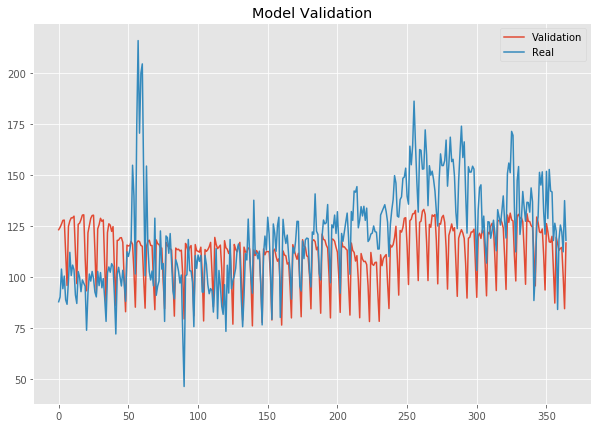

In [98]:
plt.figure(figsize=(10,7))
plt.plot(pred)
plt.plot(np.array(test.value))
plt.legend(['Validation','Real'])
plt.title('Model Validation')
plt.show()

In [34]:
print("MSE relativo modello LSTM", np.mean((np.array(test.value) - pred)**2)) #MSE
print("MAE relativo modello LSTM", np.mean(np.abs(np.array(test.value) - pred))) #MAE

MSE relativo modello LSTM 837.4082645654071
MAE relativo modello LSTM 22.682800538858793


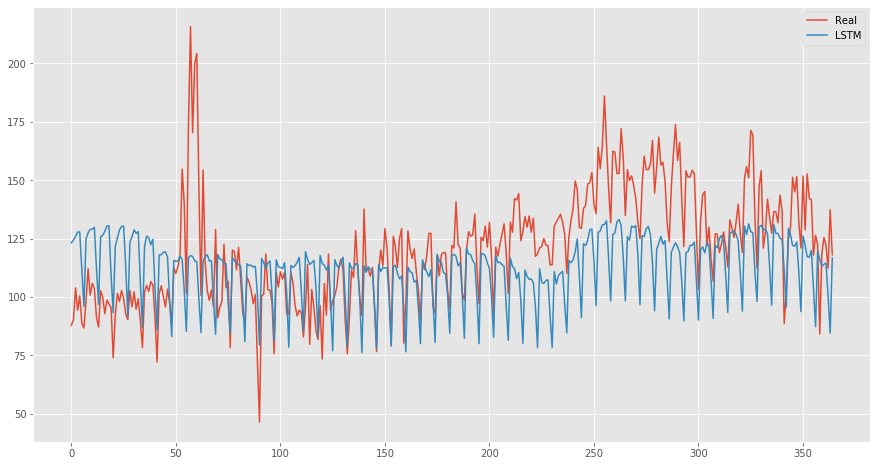

In [35]:
plt.figure(figsize=(15,8))

real, = plt.plot(np.array(test.value))
lstm, = plt.plot(pred)

plt.legend([real,lstm],
           ['Real','LSTM'])

plt.show()

In [56]:
%%R

mse_reg <- mean((test - mod_reg_y)^2)
mse_2   <- mean((test - mod2_y)^2)
mse_ucm   <- mean((test - ucm_y)^2)

print(paste0("MSE relativo modello ARIMA : ", mse_2))
print(paste0("MSE relativo modello XARIMA : ", mse_reg))
print(paste0("MSE relativo modello UCM : ", mse_ucm))

mae_reg <- mean(abs(test - mod_reg_y))
mae_2   <- mean(abs(test - mod2_y))
mae_ucm   <- mean(abs(test - ucm_y))
print("")
print(paste0("MAE relativo modello ARIMA : ", mae_2))
print(paste0("MAE relativo modello XARIMA : ", mae_reg))
print(paste0("MAE relativo modello UCM : ", mae_ucm))

[1] "MSE relativo modello ARIMA : 600.229269670712"
[1] "MSE relativo modello XARIMA : 650.642457897501"
[1] "MSE relativo modello UCM : 861.017046144573"
[1] ""
[1] "MAE relativo modello ARIMA : 18.8319046824853"
[1] "MAE relativo modello XARIMA : 20.4267405589068"
[1] "MAE relativo modello UCM : 23.8601959335099"


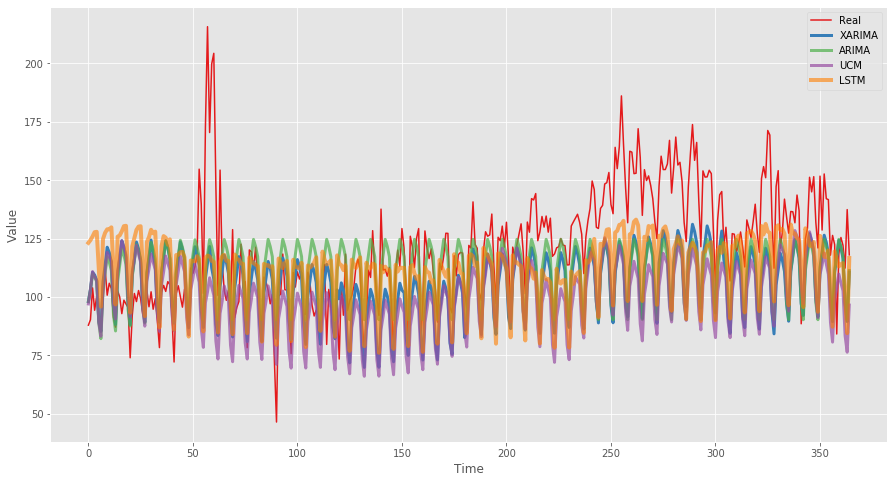

In [57]:
%R -o mod_reg_y -o mod2_y -o ucm_y

plt.figure(figsize=(15,8))
real, = plt.plot(np.array(test.value), color="#e41a1c")
xarima, = plt.plot(np.array(mod_reg_y), color="#377eb8",linewidth=3)
arima, = plt.plot(np.array(mod2_y), color="#4daf4a", linewidth=3, alpha=0.7)
ucm, = plt.plot(np.array(ucm_y), color="#984ea3", linewidth=3, alpha=0.7)
lstm, = plt.plot(pred, color="#ff7f00", linewidth=4, alpha=0.6)

plt.legend([real,xarima,arima, ucm, lstm],
           ['Real','XARIMA','ARIMA','UCM','LSTM']) 

plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

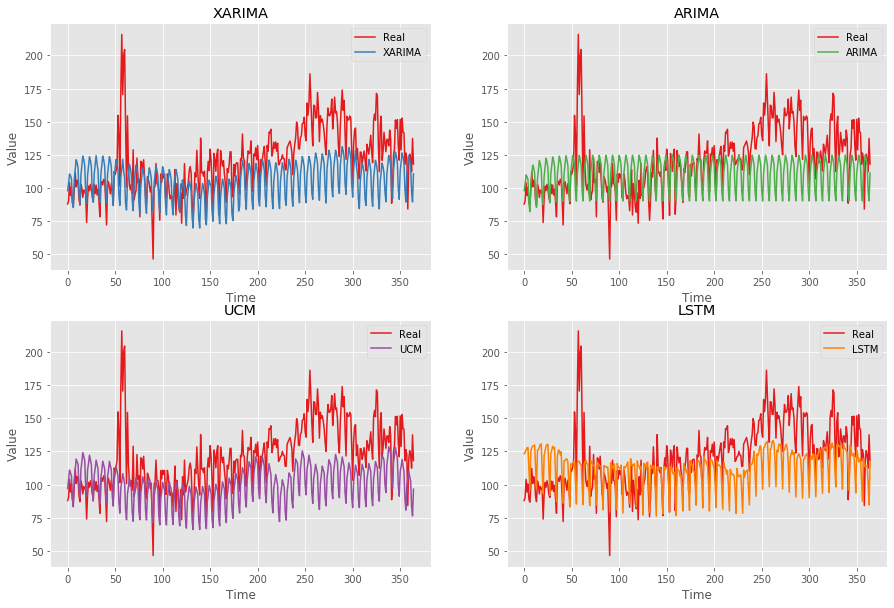

In [58]:
plt.figure(figsize=(15,10))

plt.subplot(221)
real, = plt.plot(np.array(test.value), color="#e41a1c")
xarima, = plt.plot(np.array(mod_reg_y), color="#377eb8")

plt.legend([real,xarima],
           ['Real','XARIMA']) 

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("XARIMA")


plt.subplot(222)
real, = plt.plot(np.array(test.value), color="#e41a1c")
arima, = plt.plot(np.array(mod2_y), color="#4daf4a")


plt.legend([real,arima],
           ['Real','ARIMA']) 

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("ARIMA")


plt.subplot(223)
real, = plt.plot(np.array(test.value), color="#e41a1c")
ucm, = plt.plot(np.array(ucm_y), color="#984ea3")

plt.legend([real, ucm,],
           ['Real','UCM']) 

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("UCM")



plt.subplot(224)
real, = plt.plot(np.array(test.value), color="#e41a1c")
lstm, = plt.plot(pred, color="#ff7f00")

plt.legend([real, lstm],
           ['Real','LSTM']) 

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("LSTM")


plt.savefig("Comparision.png")
plt.show()